# Load cache


In [61]:
import cache_magic

%cache magic is now registered in ipython


# Data download

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lux 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/olist_order_payments_dataset.csv
./data/olist_sellers_dataset.csv
./data/olist_order_reviews_dataset.csv
./data/olist_order_items_dataset.csv
./data/olist_orders_dataset.csv
./data/olist_geolocation_dataset.csv
./data/olist_products_dataset.csv
./data/olist_customers_dataset.csv
./data/product_category_name_translation.csv


In [2]:
customers = pd.read_csv("./data/olist_customers_dataset.csv")
sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")
items = pd.read_csv("./data/olist_order_items_dataset.csv")
products = pd.read_csv("./data/olist_products_dataset.csv")
geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
orders = pd.read_csv("./data/olist_orders_dataset.csv")
order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")

## Merge datasets

In [3]:
datasets = [customers, sellers, reviews, items, products, geolocation, category_name_translation, orders, order_payments]

In [4]:
df = orders.merge(items, on="order_id").merge(products, on = "product_id").merge(sellers, on="seller_id").merge(customers, on="customer_id")

In [5]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   order_item_id                  112650 non-null  int64  
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

# Data cleaning

In [6]:
#date_cols = [order_delivered_customer_date", "order_estimated_delivery_date", "order_purchase_timestamp", "order_delivered_customer_date"]

df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

df['expected_delivery_timedelta'] = pd.to_numeric(df['order_estimated_delivery_date']- df["order_purchase_timestamp"])
df['delivery_time'] = pd.to_numeric(df["order_delivered_customer_date"] - df['order_purchase_timestamp'])

df['product_volume'] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]

df["same_city"] = df["customer_city"] == df["seller_city"]
df["same_state"] = df["customer_state"] == df["seller_state"]

In [7]:
#df.drop(["expected_delivery_timedelta"], axis = 1, inplace=True)

In [8]:
df

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/vislib/altair/Histogram.py:47: RuntimeWarning:overflow encountered in long_scalars


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [9]:
df.info()

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

## Detecting outliers in numerical data

In [10]:
unique_orders_count = df.groupby(["customer_id"])["order_id"].count() # Count unique orders
nof_moest_popular_sales = df.groupby(["customer_id"])["seller_id"].agg(lambda x:x.value_counts()[0]) # Number of orders from most popular sellers
max_sale = df.groupby(["customer_id"])["price"].max() # Most money spent on single order
median_sale = df.groupby(["customer_id"])["price"].median() # Median money spent on orders
sum_sale = df.groupby(["customer_id"])["price"].sum() # Median money spent on orders

median_volume = df.groupby(["customer_id"])["product_volume"].median() # Median volume of products in orders
max_volume = df.groupby(["customer_id"])["product_volume"].max() # Median money spent on orders

average_delivery_time = df.groupby(["customer_id"])["delivery_time"].max() # Average delivery time
average_expected_delivery_time = df.groupby(["customer_id"])["expected_delivery_timedelta"].max() # Average delivery time


unique_orders_count.name = "unique_orders_count"
nof_moest_popular_sales.name = "nof_moest_popular_sales"
max_sale.name = "max_sale"
median_sale.name = "median_sale"
sum_sale.name = "sum_sale"
median_volume.name = "median_volume"
average_delivery_time.name = "average_delivery_time"
average_expected_delivery_time.name = "average_expected_delivery_time"

In [62]:
%cache customers2 = customers.set_index("customer_id")

creating new value for variable 'customers2'


In [12]:
customers2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [13]:
%cache df2 = customers2.join([unique_orders_count, nof_moest_popular_sales, max_sale, median_sale, sum_sale, median_volume, average_delivery_time,average_expected_delivery_time],  how="outer")

In [14]:
df2[df2["unique_orders_count"] > 1]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [15]:
cat_attributes = ["customer_city", "customer_state"]
num_attributes = ["unique_orders_count", "nof_moest_popular_sales", "max_sale", "median_sale", "sum_sale", "median_volume", "average_delivery_time","average_expected_delivery_time"]

In [16]:
df2['average_expected_delivery_time'] = df2['average_expected_delivery_time']
df2['average_delivery_time'] = df2['average_delivery_time']

In [17]:
df2.fillna(df2.mean(), inplace=True)

In [18]:
df2.info()

<class 'lux.core.frame.LuxDataFrame'>
Index: 99441 entries, 06b8999e2fba1a1fbc88172c00ba8bc7 to 274fa6071e5e17fe303b9748641082c8
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_unique_id              99441 non-null  object 
 1   customer_zip_code_prefix        99441 non-null  int64  
 2   customer_city                   99441 non-null  object 
 3   customer_state                  99441 non-null  object 
 4   unique_orders_count             99441 non-null  float64
 5   nof_moest_popular_sales         99441 non-null  float64
 6   max_sale                        99441 non-null  float64
 7   median_sale                     99441 non-null  float64
 8   sum_sale                        99441 non-null  float64
 9   median_volume                   99441 non-null  float64
 10  average_delivery_time           99441 non-null  float64
 11  average_expected_delivery_time  99441 no

In [19]:
df2.groupby("customer_city")["customer_state"].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [20]:
groupby_col="customer_city"

In [21]:
other_countes = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[21:,:].reset_index()[groupby_col].array

In [22]:
df2.loc[df2.customer_city.isin(other_countes), "customer_city"] = "other"

In [23]:
df2.customer_city.nunique()

22

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_attributes),
        ('cat', OneHotEncoder(), cat_attributes),
])
df_prepared = pipeline.fit_transform(df2)
df_prepared

<99441x57 sparse matrix of type '<class 'numpy.float64'>'
	with 991310 stored elements in Compressed Sparse Row format>

In [25]:
%cache df3 = df_prepared.toarray()

In [26]:
len(num_attributes)

8

In [27]:
import lux
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# HDBSCAN

In [63]:
import hdbscan
%cache clusterer = hdbscan.HDBSCAN(min_cluster_size=600, min_samples=80, cluster_selection_epsilon=0.6)

creating new value for variable 'clusterer'


In [65]:
#clusterer.fit(df3[np.random.choice(df3.shape[0],50000, replace=False),:])
%cache clusterer = clusterer.fit(df3)

creating new value for variable 'clusterer'


In [30]:
max(clusterer.labels_)

29

<AxesSubplot:ylabel='Count'>

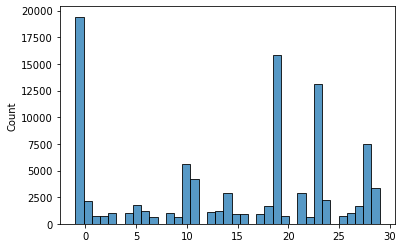

In [31]:
import seaborn as sns
sns.histplot(clusterer.labels_)

# UMAP

In [32]:
import umap

2021-08-08 16:46:50.411488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [33]:
import umap.plot

In [66]:
%cache mapper = umap.UMAP(densmap=True).fit(df3)

creating new value for variable 'mapper'


/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


<AxesSubplot:>

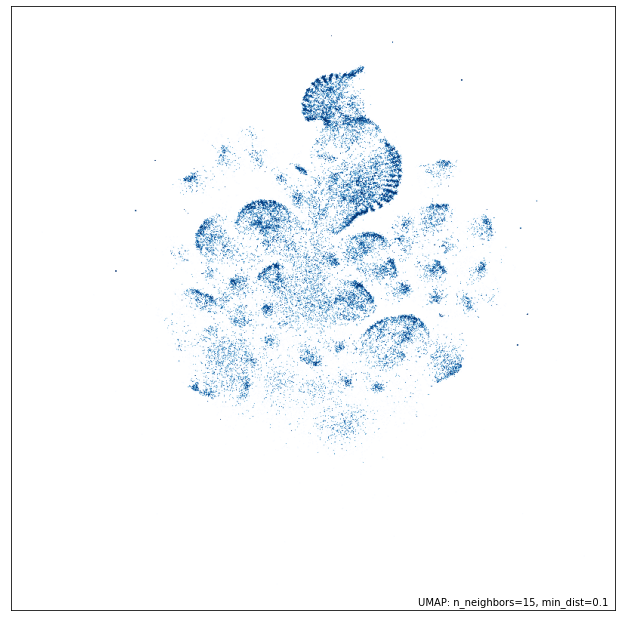

In [35]:
umap.plot.points(mapper)

## HDBSCAN viz

<AxesSubplot:>

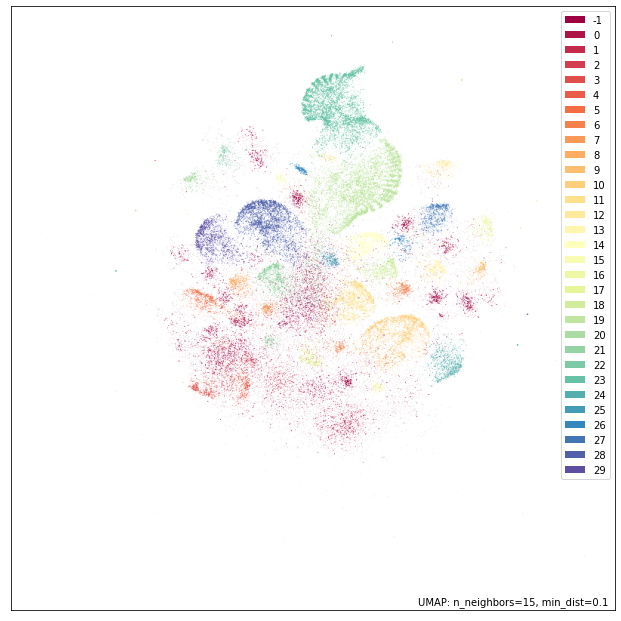

In [36]:
umap.plot.points(mapper, labels=clusterer.labels_)

In [37]:
df3.data

In [38]:
df3.shape

(99441, 57)

In [39]:
df3

array([[-0.26425169, -0.24920597, -0.00859807, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.85036823, ...,  0.        ,
         1.        ,  0.        ],
       [-0.26425169, -0.24920597,  0.06969927, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.26425169, -0.24920597, -0.46942634, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597,  2.94528026, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26425169, -0.24920597, -0.58993616, ...,  0.        ,
         1.        ,  0.        ]])

# KMEANS

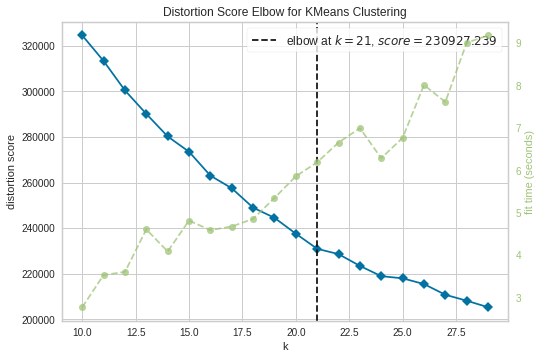

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()

visualizer = KElbowVisualizer(model, k=(10,30), timings=True)
visualizer.fit(df3)
visualizer.show()

In [41]:
X = df3
kmeans = KMeans(n_clusters=21, random_state=0, copy_x=False).fit(X)

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:786: FutureWarning:'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect


In [42]:
kmeans.labels_

array([ 4, 15, 15, ..., 20,  8, 18], dtype=int32)

<AxesSubplot:ylabel='Count'>

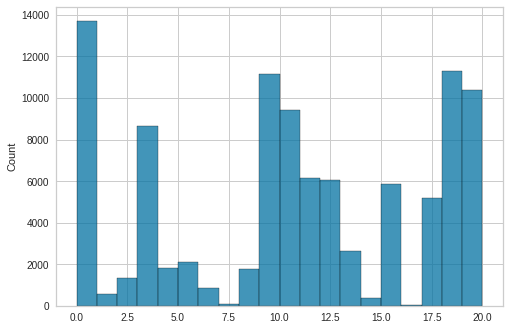

In [43]:
sns.histplot(kmeans.labels_, bins=max(kmeans.labels_))

## Kmeans viz

<AxesSubplot:>

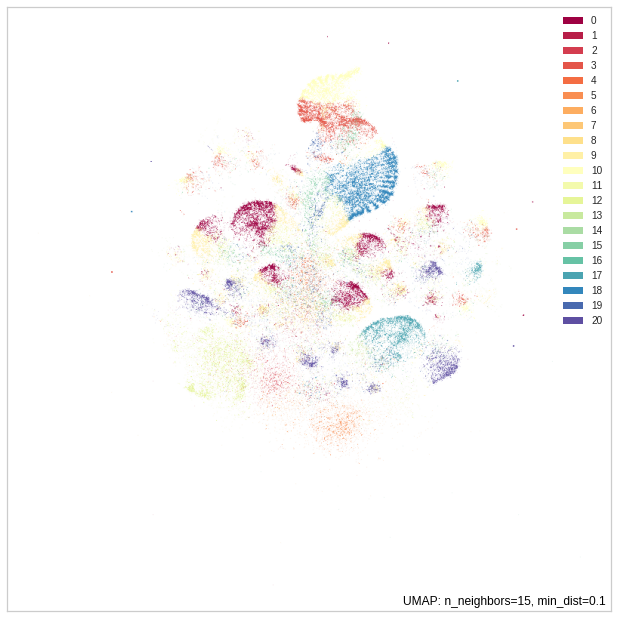

In [44]:
umap.plot.points(mapper, labels=kmeans.labels_)

In [45]:
points = mapper.embedding_

In [46]:
points[:,0]

array([ 1.843174  , -7.1535196 ,  6.527419  , ...,  8.987339  ,
       -0.89191645, 10.583327  ], dtype=float32)

In [47]:
df2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [48]:
#umap.plot.connectivity(mapper, show_points=True, labels=kmeans.labels_)

In [49]:
#umap.plot.connectivity(mapper, edge_bundling='hammer')

In [50]:
import seaborn as sns

In [51]:
points

array([[  1.843174  ,   2.9069722 ],
       [ -7.1535196 ,  12.820281  ],
       [  6.527419  ,  17.415934  ],
       ...,
       [  8.987339  , -10.428722  ],
       [ -0.89191645,  -0.66407406],
       [ 10.583327  ,  10.91905   ]], dtype=float32)

In [52]:
df2["x"] = points[:,0]
df2["y"] = points[:,1]

In [53]:
df2['y']

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [54]:
df2

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/IPython/core/formatters.py:918: UserWarning:
Unexpected error in rendering Lux widget and recommendations. Falling back to Pandas display.
Please report the following issue on Github: https://github.com/lux-org/lux/issues 

/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/core/frame.py:628: UserWarning:Traceback (most recent call last):
  File "/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/core/frame.py", line 590, in _ipython_display_
    self.maintain_recs()
  File "/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/core/frame.py", line 432, in maintain_recs
    custom_action_collection = custom_actions(rec_df)
  File "/home/pk/miniconda3/envs/data-science-notebooks/lib/python3.8/site-packages/lux/action/custom.py", line 76, in custom_actions
    recommendation = lux.config.actions[action_name].action(ldf)
  File "/h

customer_unique_id  \
customer_id                                                          
06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                                            ...   
17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

                                  customer_zip_code_prefix  \
customer_id                                                  
06b8999e2fba1a1fbc88172c00ba8bc7                     14409   
18955e83d337fd6b2def6b18a428ac77                      9790   
4e7b3e00288586ebd08712fdd0374a03                      1151   
b2b6027bc5c5109e529d4dc6358b12c3                      8775   
4f2d8ab171c80ec8364f7c12e35b23ad                     13056   
...                                                    ...   
17ddf5dd5d51696bb3d7c6291687be6f                      3937   
e7b71a9017aa05c9a7fd292d714858e8                      6764   
5e28dfe12db7fb50a4b2f691faecea5e                     60115   
56b18e2166679b8a959d72dd06da27f9                     92120   
274fa6071e5e17fe303b9748641082c8                      6703   

                                          customer_city customer_state  \
customer_id                                                              
06b8999e2fba1a1fbc88172c00ba8bc7                  other             SP   
18955e83d337fd6b2def6b18a428ac77  sao bernardo do campo             SP   
4e7b3e00288586ebd08712fdd0374a03              sao paulo             SP   
b2b6027bc5c5109e529d4dc6358b12c3                  other             SP   
4f2d8ab171c80ec8364f7c12e35b23ad               campinas             SP   
...                                                 ...            ...   
17ddf5dd5d51696bb3d7c6291687be6f              sao paulo             SP   
e7b71a9017aa05c9a7fd292d714858e8                  other             SP   
5e28dfe12db7fb50a4b2f691faecea5e              fortaleza             CE   
56b18e2166679b8a959d72dd06da27f9                  other             RS   
274fa6071e5e17fe303b9748641082c8                  other             SP   

                                  unique_orders_count  \
customer_id                                             
06b8999e2fba1a1fbc88172c00ba8bc7                  1.0   
18955e83d337fd6b2def6b18a428ac77                  1.0   
4e7b3e00288586ebd08712fdd0374a03                  1.0   
b2b6027bc5c5109e529d4dc6358b12c3                  1.0   
4f2d8ab171c80ec8364f7c12e35b23ad                  1.0   
...                                               ...   
17ddf5dd5d51696bb3d7c6291687be6f                  1.0   
e7b71a9017aa05c9a7fd292d714858e8                  1.0   
5e28dfe12db7fb50a4b2f691faecea5e                  1.0   
56b18e2166679b8a959d72dd06da27f9                  1.0   
274fa6071e5e17fe303b9748641082c8                  1.0   

                                  nof_moest_popular_sales  max_sale  \
customer_id                                                           
06b8999e2fba1a1fbc88172c00ba8bc7                      1.0    124.99   
18955e83d337fd6b2def6b18a428ac77                      1.0    289.00   
4e7b3e00288586ebd08712fdd0374a03                      1.0    139.94   
b2b6027bc5c5109e529d4dc6358b12c3                      1.0    149.94   
4f2d8ab171c80ec8364f7c12e35b23ad                      1.0    230.00   
...                                                   ...       ...   
17ddf5dd5d51696bb3d7c6291687be6f                      1.0

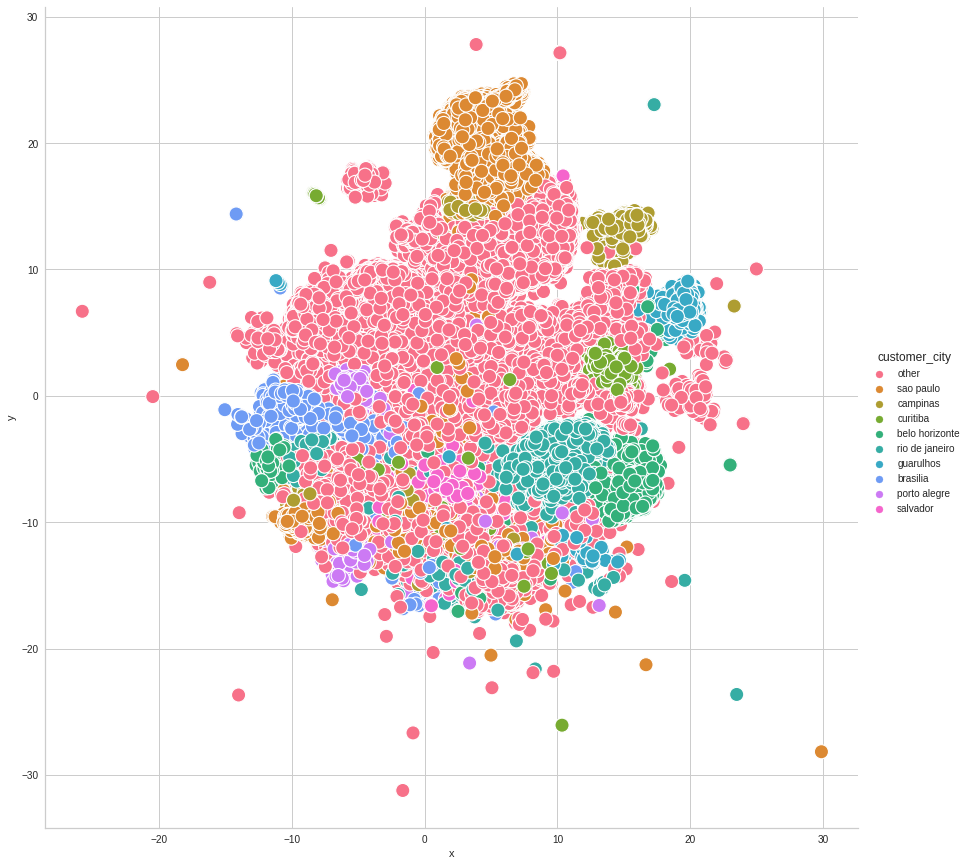

In [55]:
countries = df2.groupby('customer_city').count().sort_values('customer_state', ascending=False).iloc[0:10,:].reset_index()['customer_city'].array
sns.relplot(
    data = df2.loc[df2['customer_city'].isin(countries)],
    x = "x",
    y = "y",
    hue = 'customer_city',
    height = 12,
    s=200)

In [56]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y'],
      dtype='object')

In [67]:
%cache smapper = umap.UMAP().fit_transform(X, kmeans.labels_)

creating new value for variable 'smapper'


<AxesSubplot:>

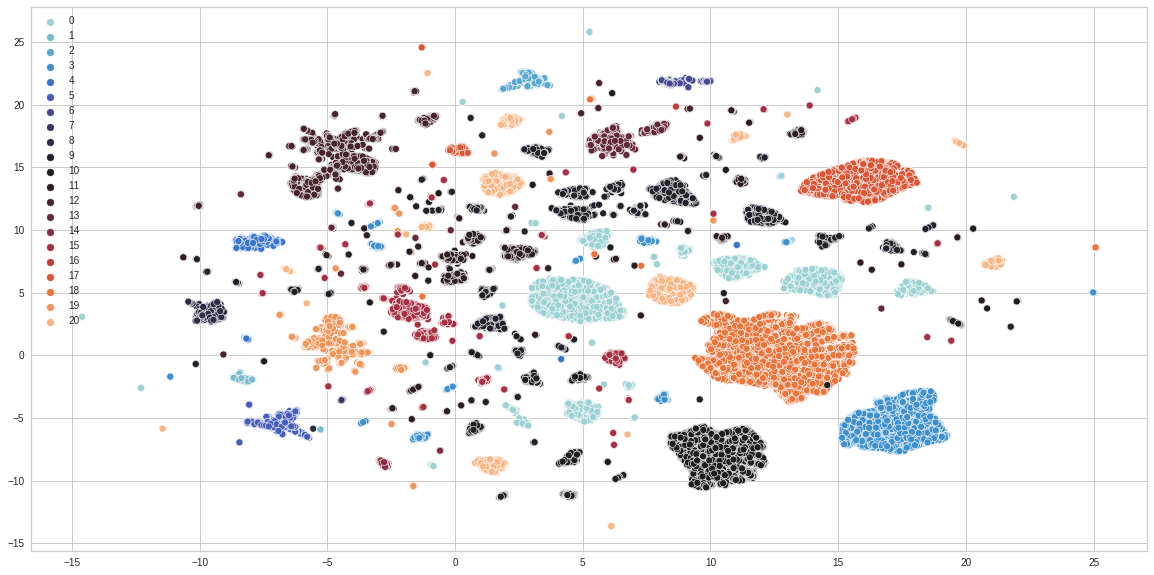

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=smapper[:,0], y=smapper[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", 21))

<AxesSubplot:>

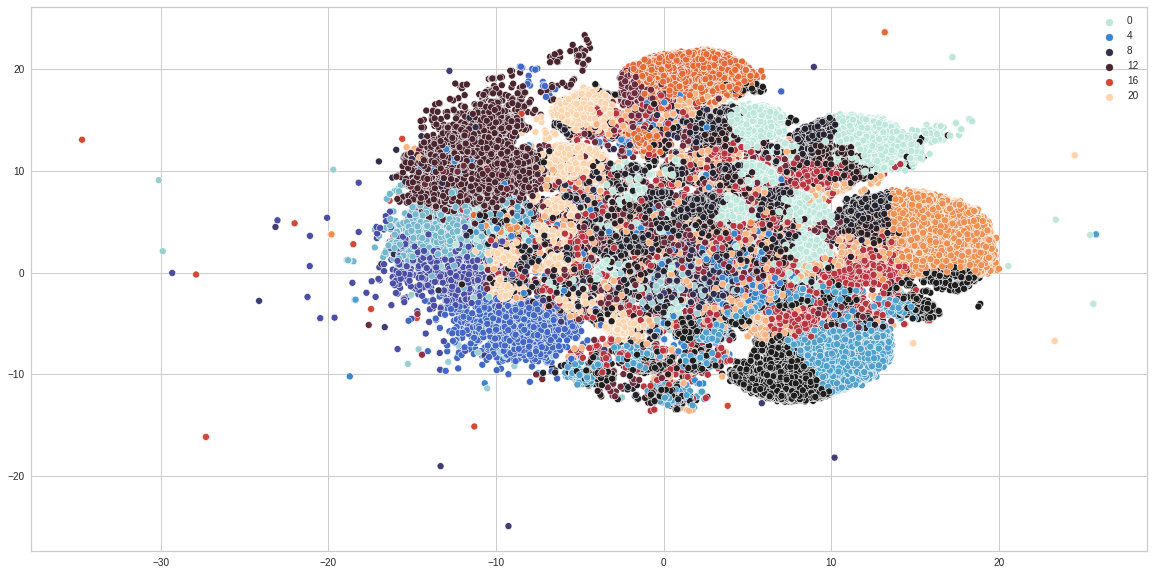

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=kmeans.labels_, ax=ax, palette=sns.color_palette("icefire", as_cmap=True))

In [71]:
df2['x1'] = smapper[:,0]
df2['y1'] = smapper[:,1]

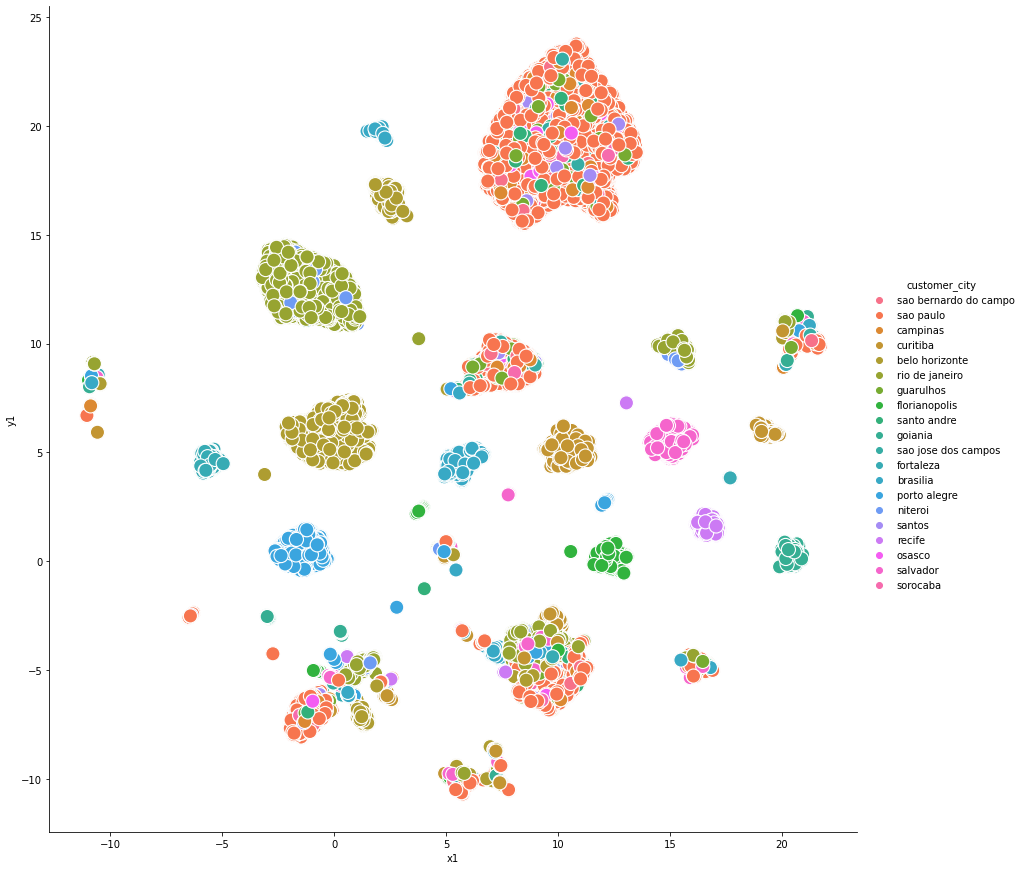

In [74]:
groupby_col="customer_city"

countries = df2.groupby(groupby_col).count().sort_values('customer_state', ascending=False).iloc[0:20,:].reset_index()[groupby_col].array

sns.relplot(
    data = df2.loc[df2[groupby_col].isin(countries)],
    x = "x1",
    y = "y1",
    hue = groupby_col,
    height = 12,
    s=200)

In [76]:
df2.loc[df2[groupby_col].isin(countries)]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [73]:
import sklearn
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)

In [74]:
outlier_scores

array([1, 1, 1, ..., 1, 1, 1])

In [75]:
df2['outlier'] = outlier_scores

In [76]:
df2.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

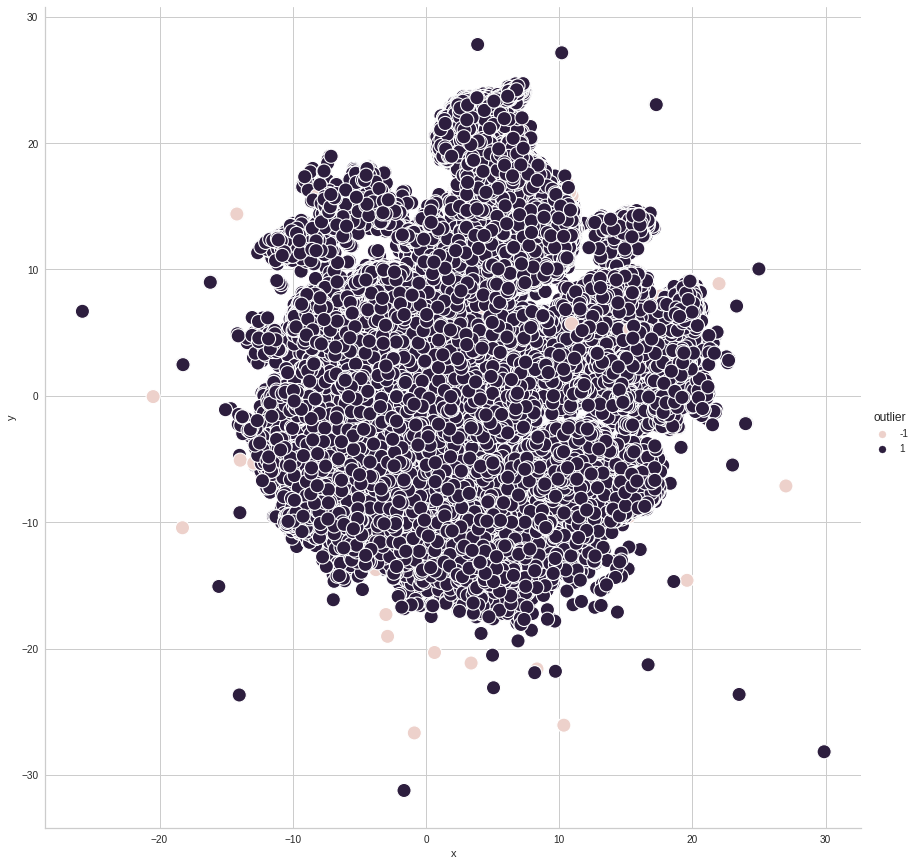

In [77]:
sns.relplot(
    data = df2,
    x = "x",
    y = "y",
    hue = "outlier",
    height = 12,
    s=200)

In [78]:
df.info(0)

<class 'lux.core.frame.LuxDataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   customer_id                    112650 non-null  object        
 2   order_status                   112650 non-null  object        
 3   order_purchase_timestamp       112650 non-null  datetime64[ns]
 4   order_approved_at              112635 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 6   order_delivered_customer_date  110196 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 8   order_item_id                  112650 non-null  int64         
 9   product_id                     112650 non-null  object        
 10  seller_id                      112650 non-null  object        
 11  

In [79]:
df4 = df.merge(df2, on="customer_unique_id")

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='product_width_cm'>

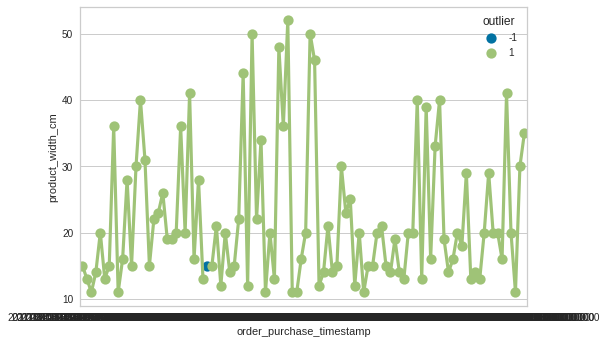

In [80]:
sns.pointplot(x="order_purchase_timestamp", y="product_width_cm", data=df4.sample(100), hue='outlier')

<AxesSubplot:xlabel='price'>

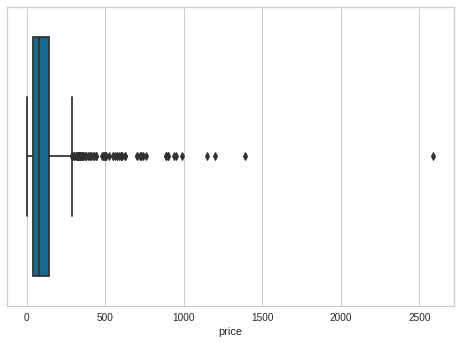

In [81]:
sns.boxplot(x="price", data=df.sample(1000))

<AxesSubplot:xlabel='product_volume'>

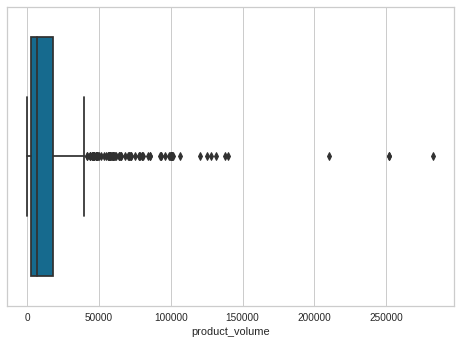

In [82]:
sns.boxplot(x="product_volume", data=df.sample(1000))

# Analizing clusters

In [83]:
df2["cluster"] = kmeans.labels_

In [84]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'outlier', 'cluster'],
      dtype='object')

<AxesSubplot:xlabel='cluster', ylabel='max_sale'>

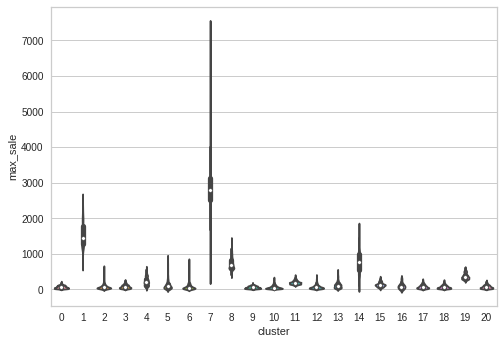

In [85]:
sns.violinplot(data=df2,x="cluster", y="max_sale")

In [86]:
# For all float columns
cols = df2.columns[df2.dtypes == "float64"]

In [87]:
import matplotlib.pyplot as plt
from pylab import *

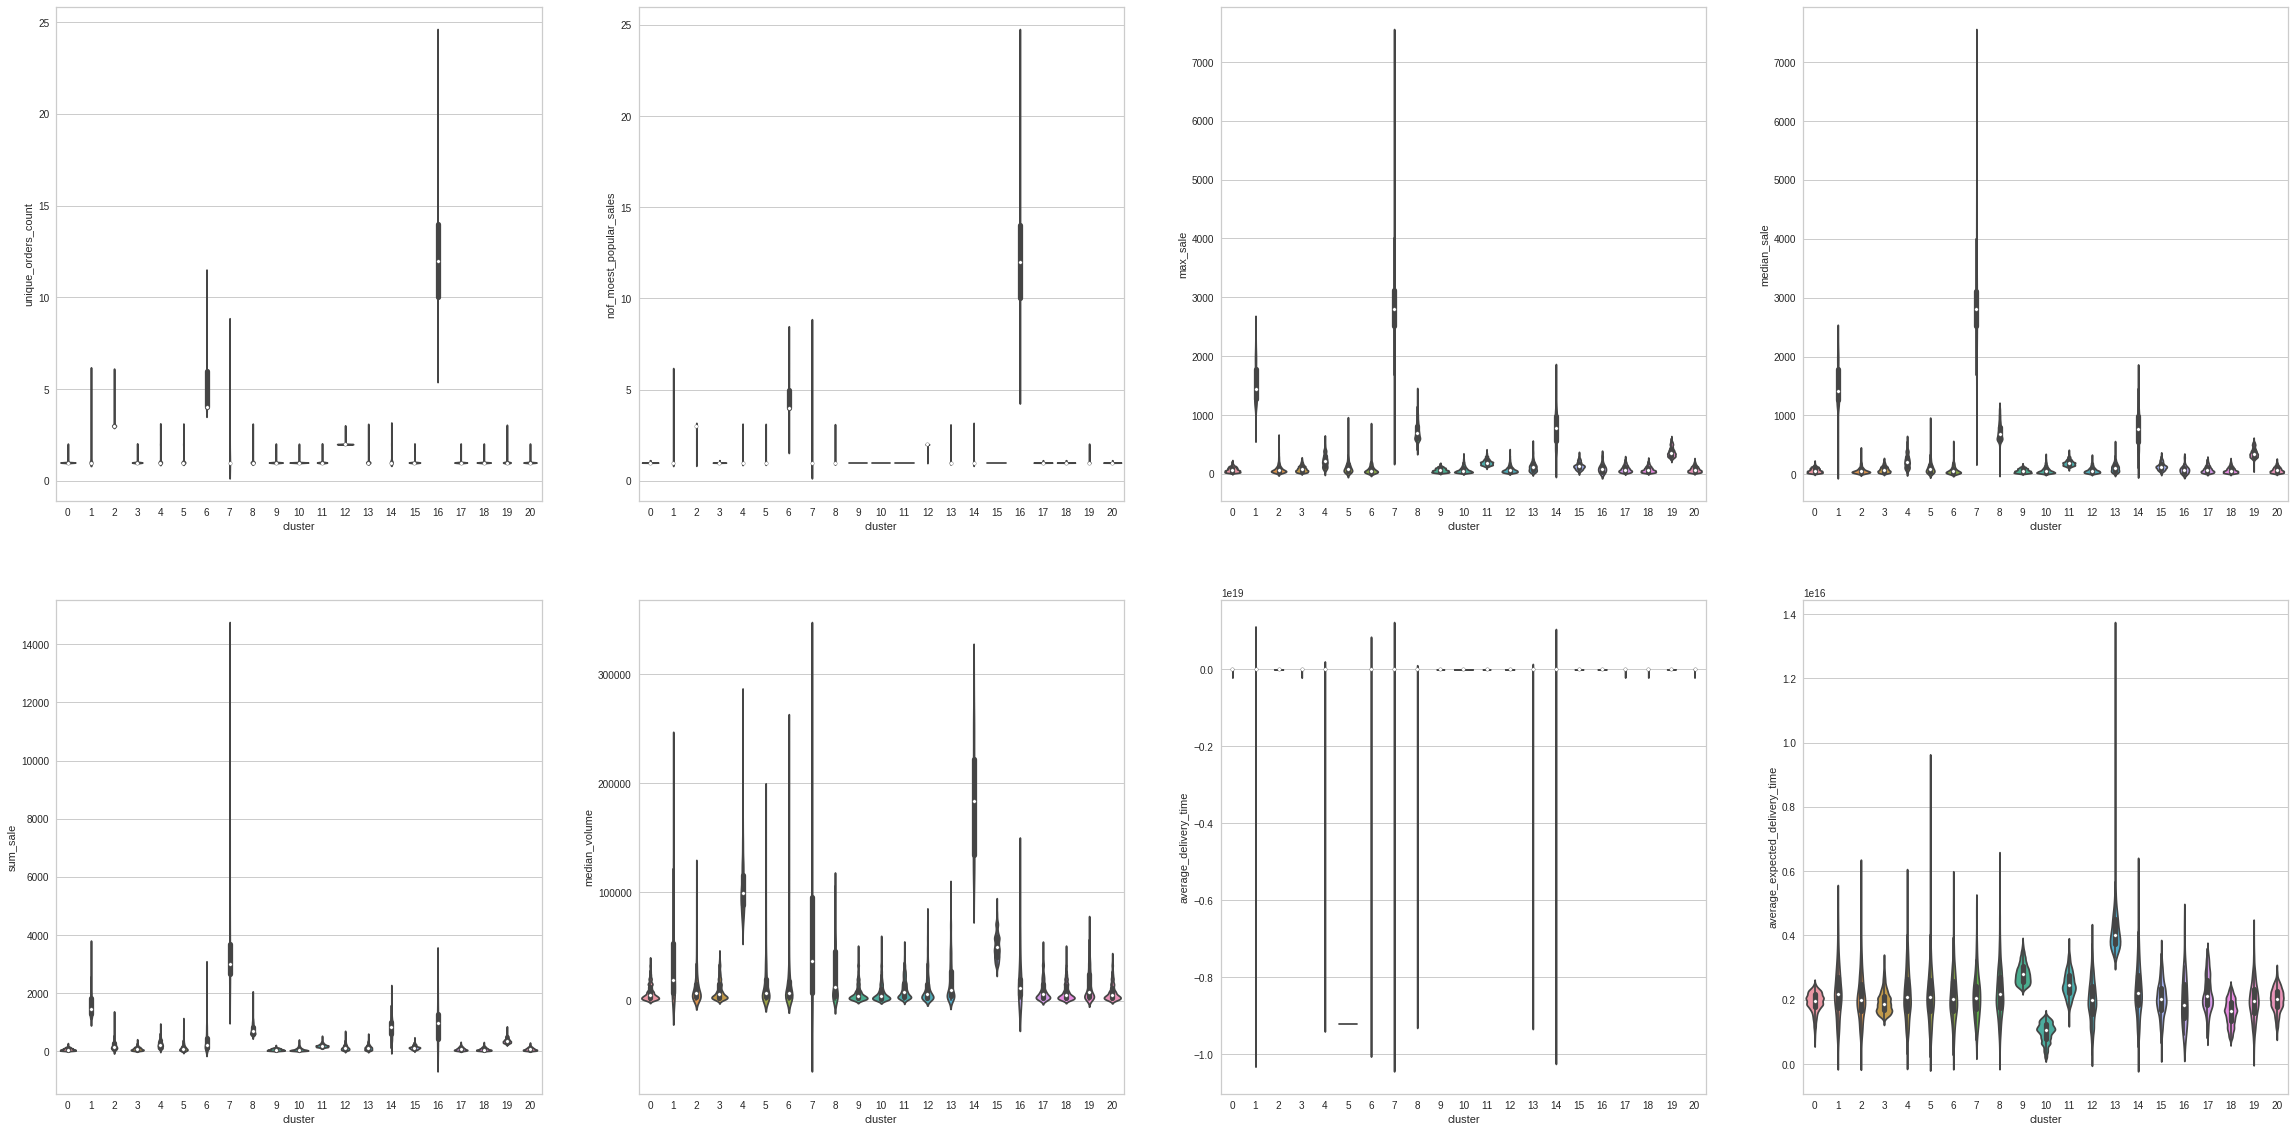

In [88]:
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(40,20))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(cols[i]))
    sns.violinplot(data=df2,x="cluster", y=cols[i], ax=ax)

In [89]:
df2.groupby("cluster").mean()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [90]:
df2.mean()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [91]:
# Author: YousefGh
# Source: https://github.com/YousefGh/kmeans-feature-importance

from sklearn.cluster import KMeans
import numpy as np


class KMeansInterp(KMeans):
    def __init__(self, ordered_feature_names, feature_importance_method='wcss_min', **kwargs):
        super(KMeansInterp, self).__init__(**kwargs)
        self.feature_importance_method = feature_importance_method
        self.ordered_feature_names = ordered_feature_names
        
    def fit(self, X, y=None, sample_weight=None):
        super().fit(X=X, y=y, sample_weight=sample_weight)
        
        if not len(self.ordered_feature_names) == self.n_features_in_:
            raise Exception(f"Model is fitted on {self.n_features_in_} but ordered_feature_names = {len(self.ordered_feature_names)}")
        
        if self.feature_importance_method == "wcss_min":
            self.feature_importances_ = self.get_feature_imp_wcss_min()
        elif self.feature_importance_method == "unsup2sup":
            self.feature_importances_ = self.get_feature_imp_unsup2sup(X)
        else: 
            raise Exception(f" {self.feature_importance_method}"+\
            "is not available. Please choose from  ['wcss_min' , 'unsup2sup']")
        
        return self
        
    def get_feature_imp_wcss_min(self):
        labels = self.n_clusters
        centroids = self.cluster_centers_
        centroids = np.vectorize(lambda x: np.abs(x))(centroids)
        sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

        cluster_feature_weights = {}
        for label, centroid in zip(range(labels), sorted_centroid_features_idx):
            ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
            ordered_cluster_features = [self.ordered_feature_names[feature] for feature in centroid]
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        
        return cluster_feature_weights
    
    def get_feature_imp_unsup2sup(self, X):
        try:
            from sklearn.ensemble import RandomForestClassifier
        except ImportError as IE:
            print(IE.__class__.__name__ + ": " + IE.message)
            raise Exception("Please install scikit-learn. " + 
                            "'unsup2sup' method requires using a classifier"+ 
                            "and depends on 'sklearn.ensemble.RandomForestClassifier'")
        
        cluster_feature_weights = {}
        for label in range(self.n_clusters):
            binary_enc = np.vectorize(lambda x: 1 if x == label else 0)(self.labels_)
            clf = RandomForestClassifier()
            clf.fit(X, binary_enc)

            sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
            ordered_cluster_features = np.take_along_axis(
                np.array(self.ordered_feature_names), 
                sorted_feature_weight_idxes, 
                axis=0)
            ordered_cluster_feature_weights = np.take_along_axis(
                np.array(clf.feature_importances_), 
                sorted_feature_weight_idxes, 
                axis=0)
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        return cluster_feature_weights

# KMeans Interpret

In [92]:
pipeline.transformers_[1][1].get_feature_names()

array(['x0_belo horizonte', 'x0_brasilia', 'x0_campinas', 'x0_curitiba',
       'x0_florianopolis', 'x0_fortaleza', 'x0_goiania', 'x0_guarulhos',
       'x0_jundiai', 'x0_niteroi', 'x0_osasco', 'x0_other',
       'x0_porto alegre', 'x0_recife', 'x0_rio de janeiro', 'x0_salvador',
       'x0_santo andre', 'x0_santos', 'x0_sao bernardo do campo',
       'x0_sao jose dos campos', 'x0_sao paulo', 'x0_sorocaba', 'x1_AC',
       'x1_AL', 'x1_AM', 'x1_AP', 'x1_BA', 'x1_CE', 'x1_DF', 'x1_ES',
       'x1_GO', 'x1_MA', 'x1_MG', 'x1_MS', 'x1_MT', 'x1_PA', 'x1_PB',
       'x1_PE', 'x1_PI', 'x1_PR', 'x1_RJ', 'x1_RN', 'x1_RO', 'x1_RR',
       'x1_RS', 'x1_SC', 'x1_SE', 'x1_SP', 'x1_TO'], dtype=object)

In [93]:
interpreter = KMeansInterp(n_clusters=21, random_state=0, copy_x=False, ordered_feature_names=np.concatenate((cols.to_numpy(), pipeline.transformers_[1][1].get_feature_names()))).fit(X)

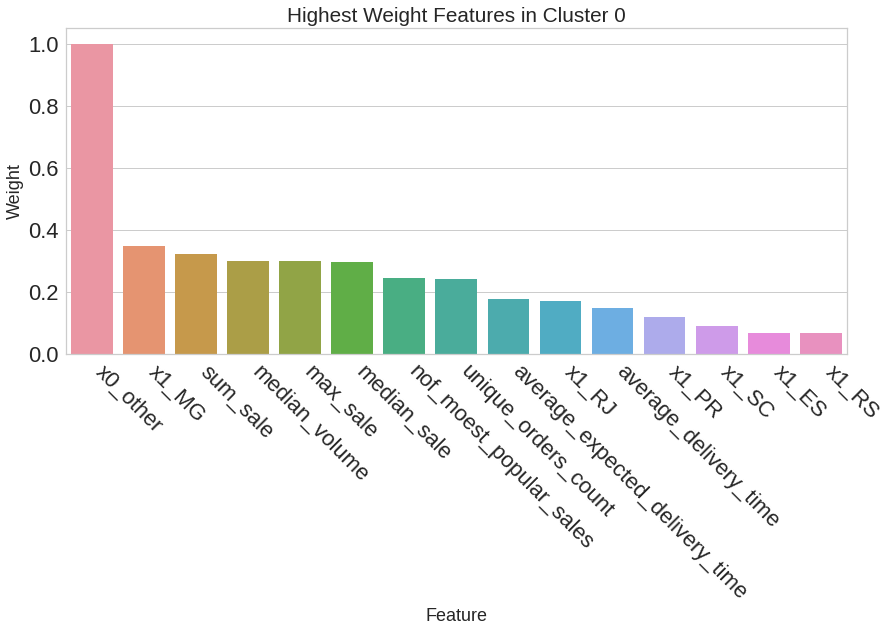

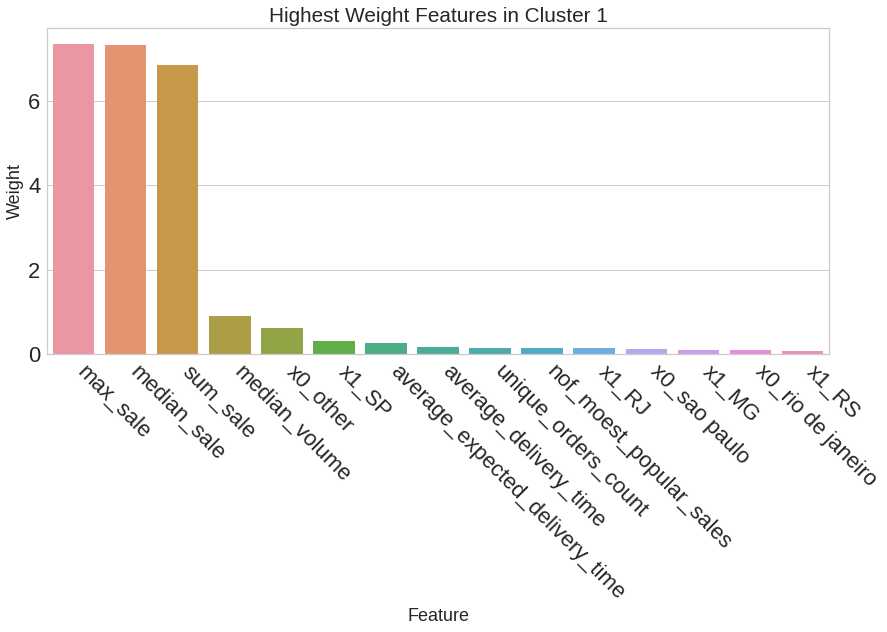

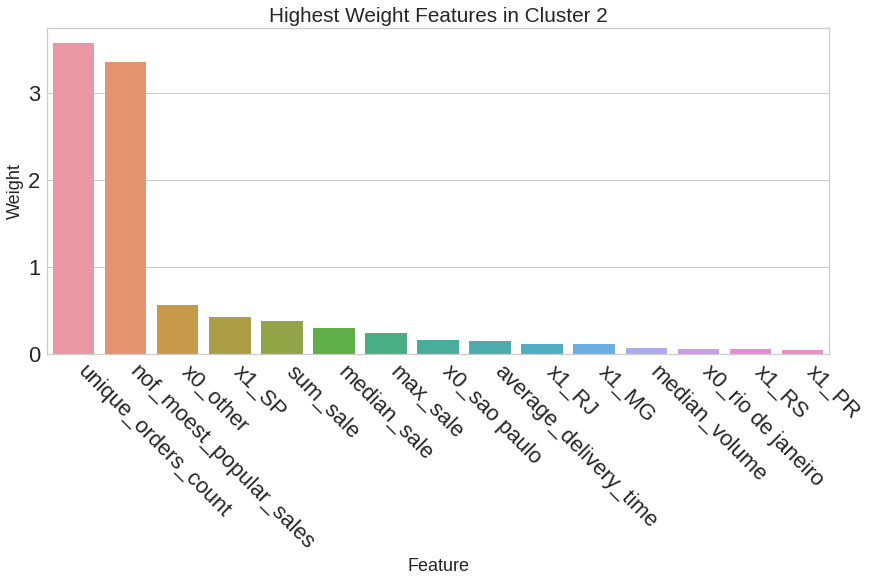

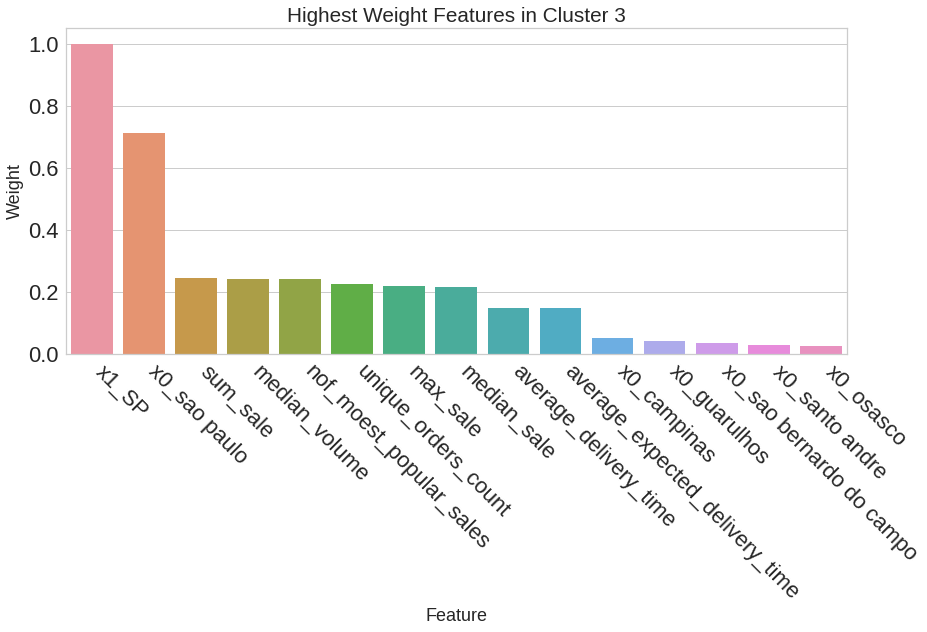

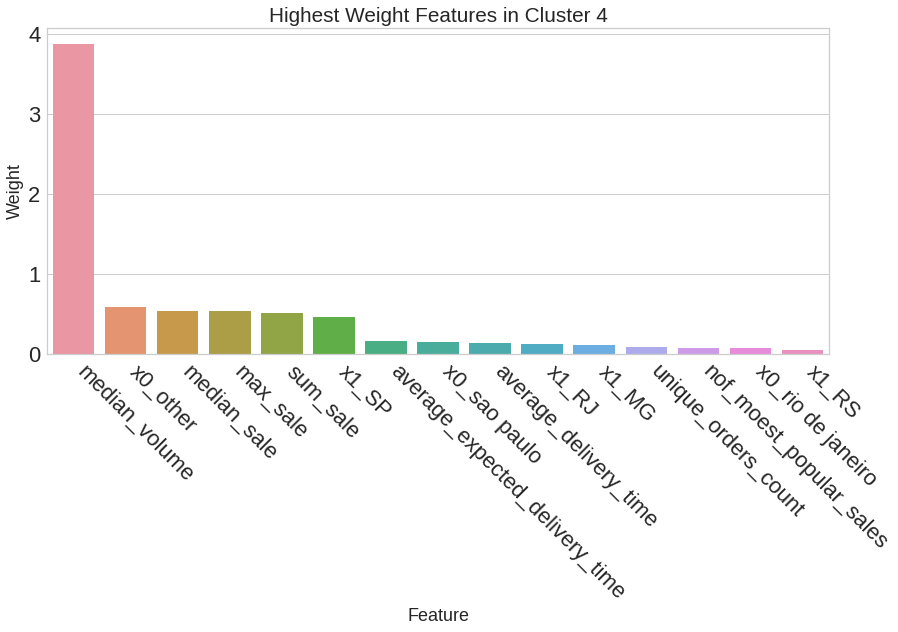

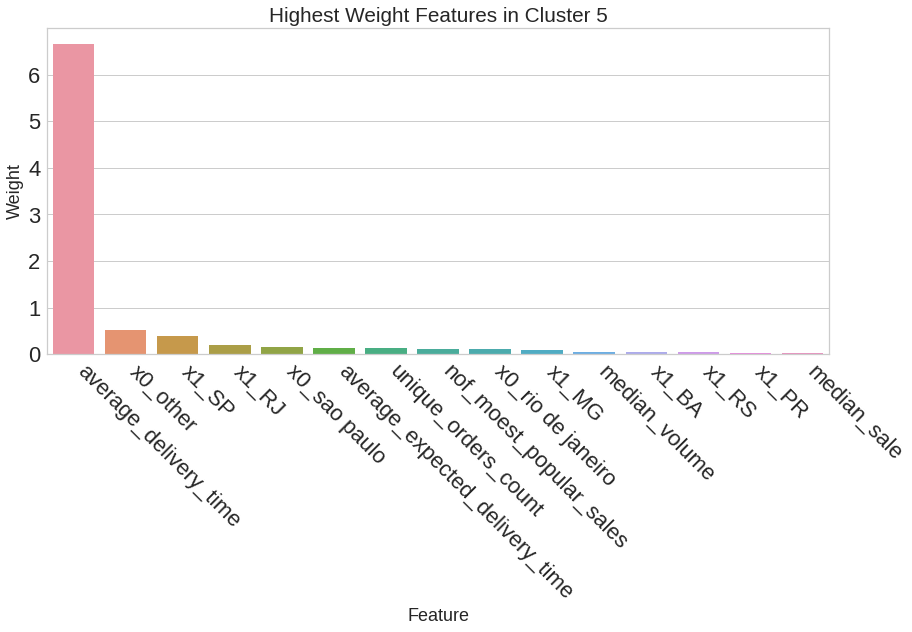

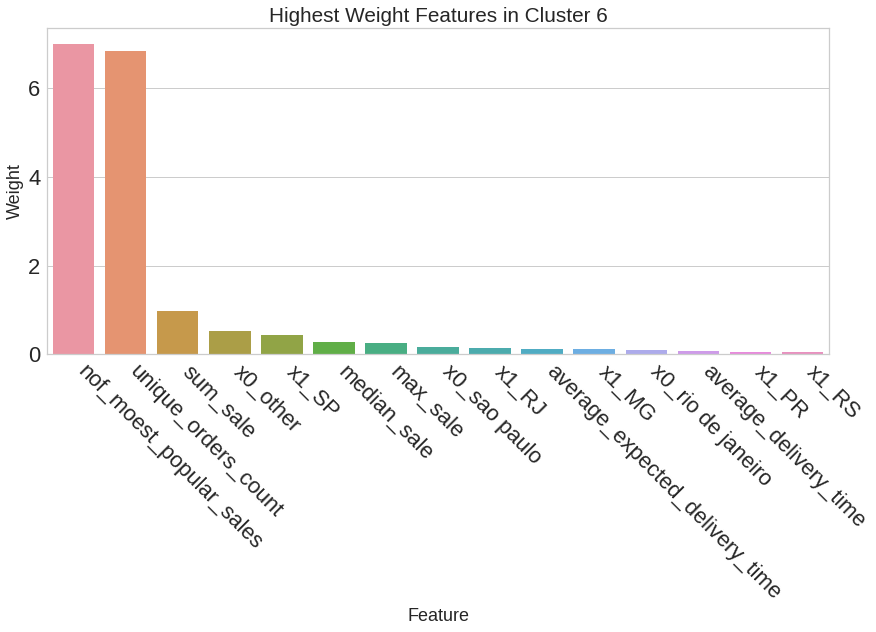

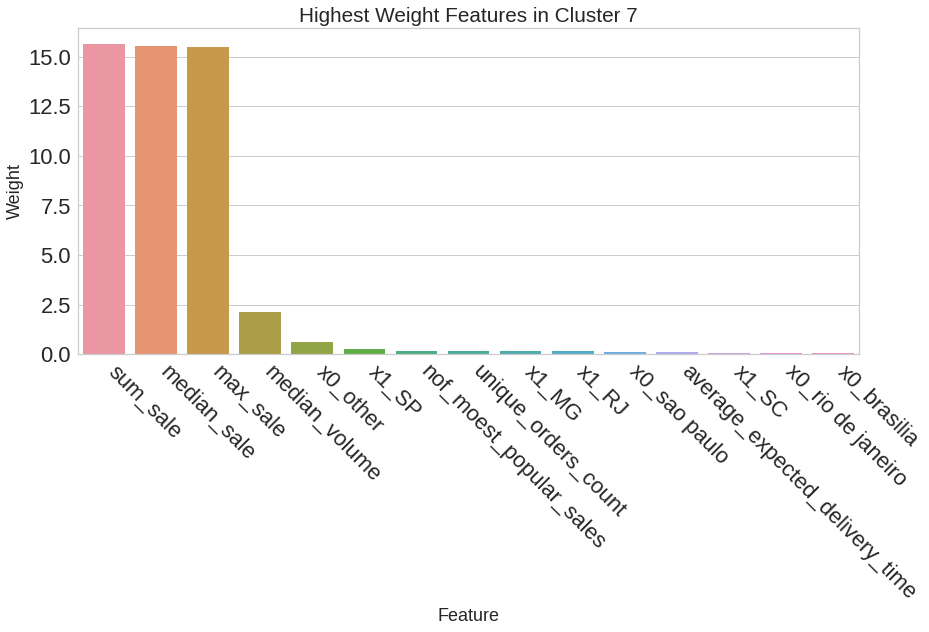

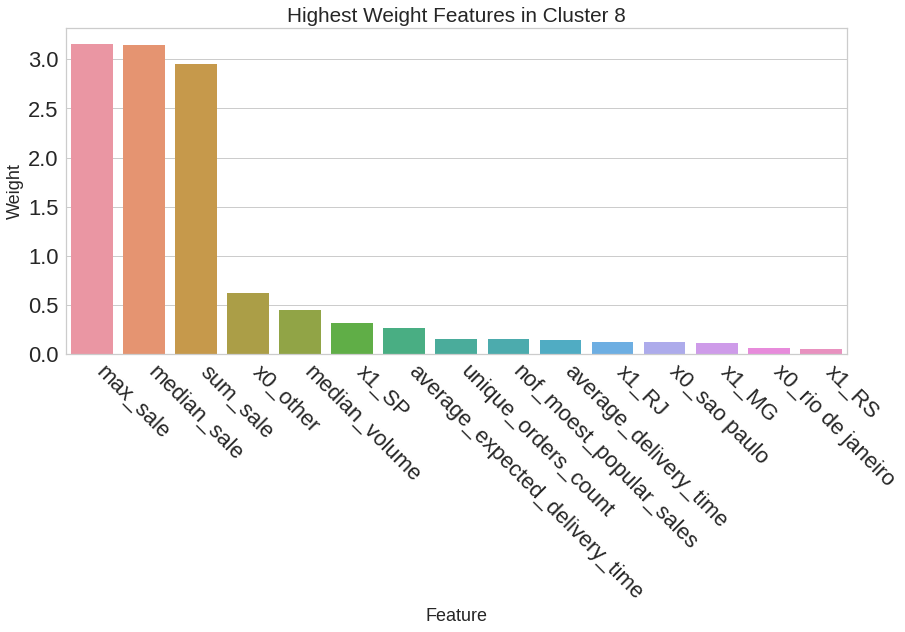

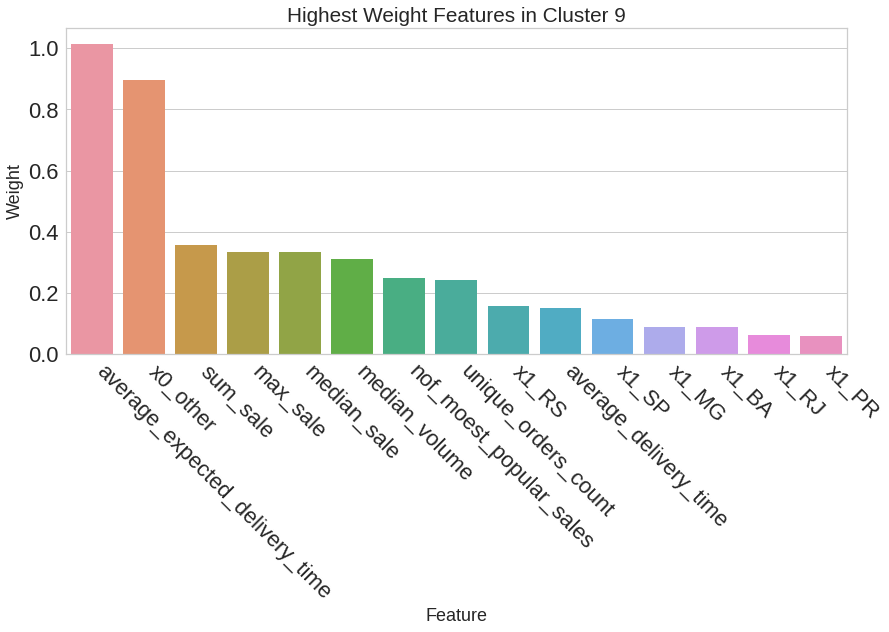

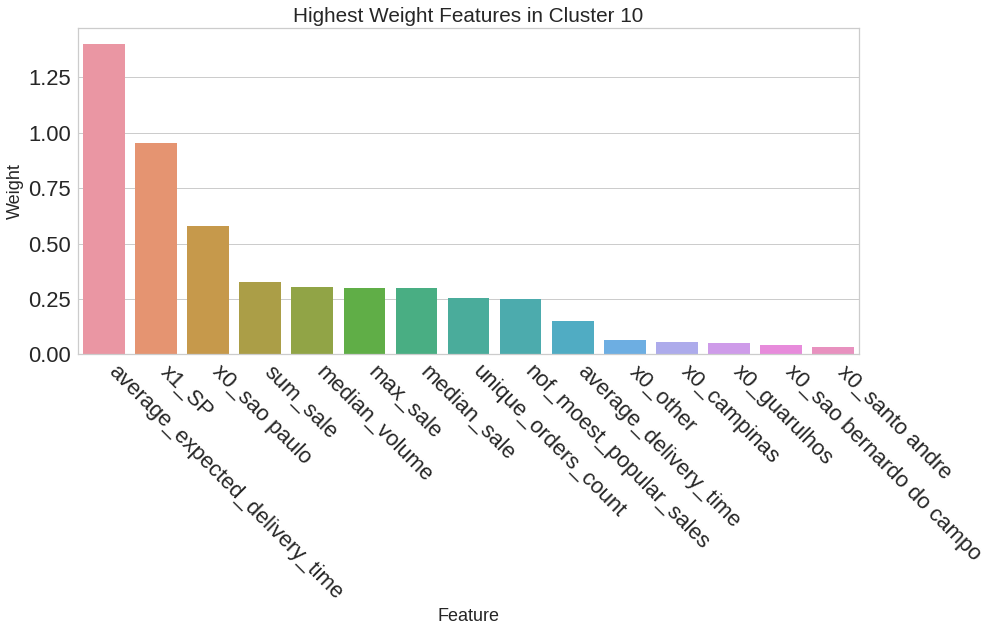

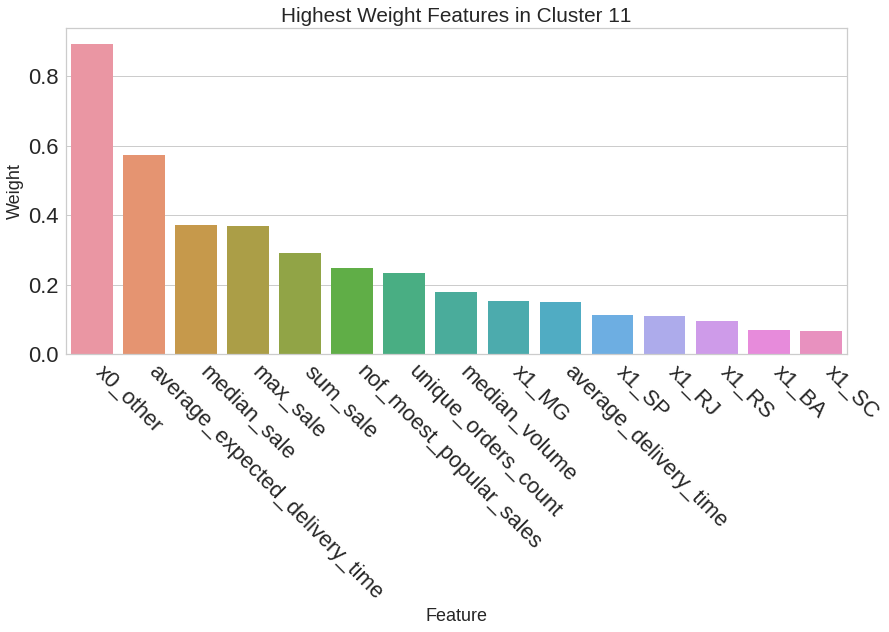

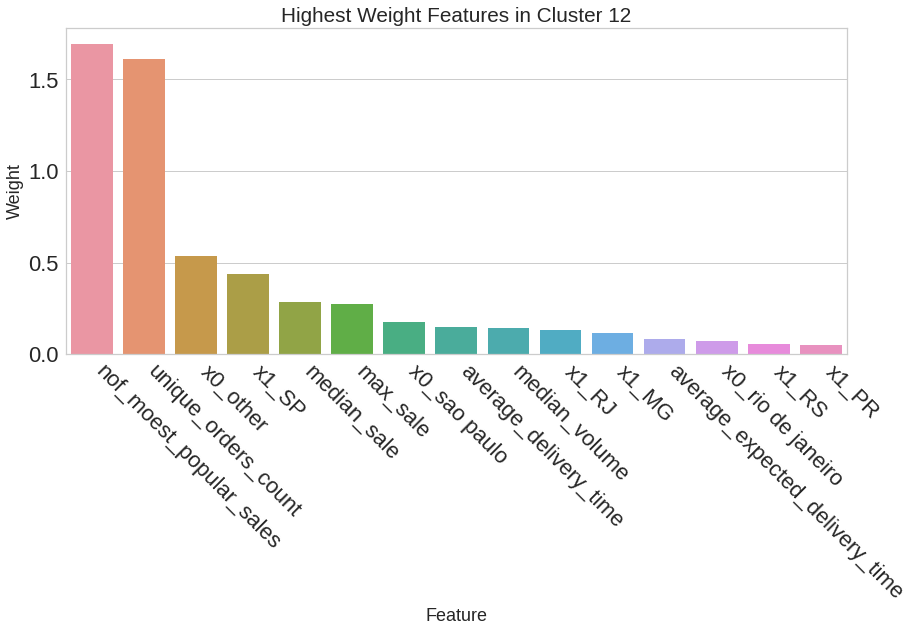

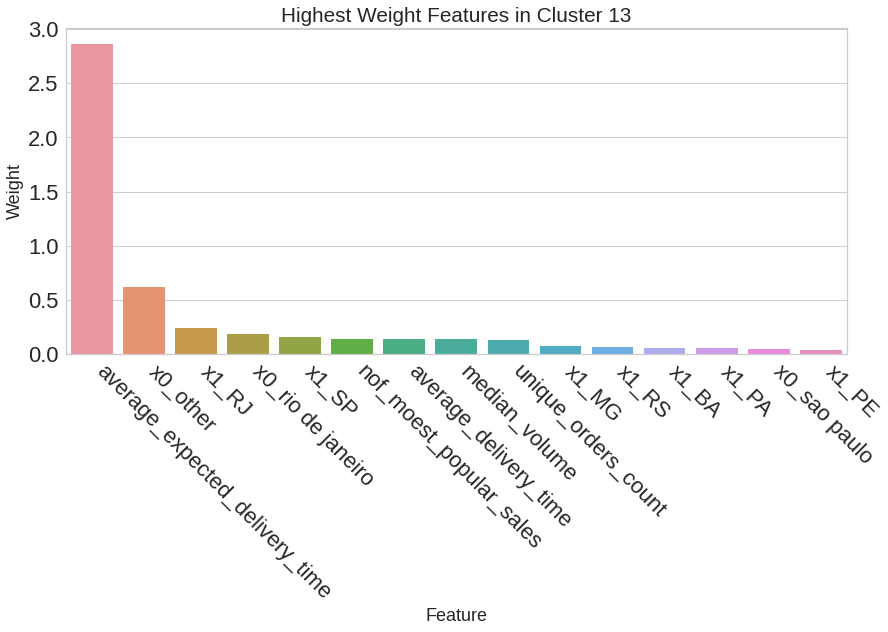

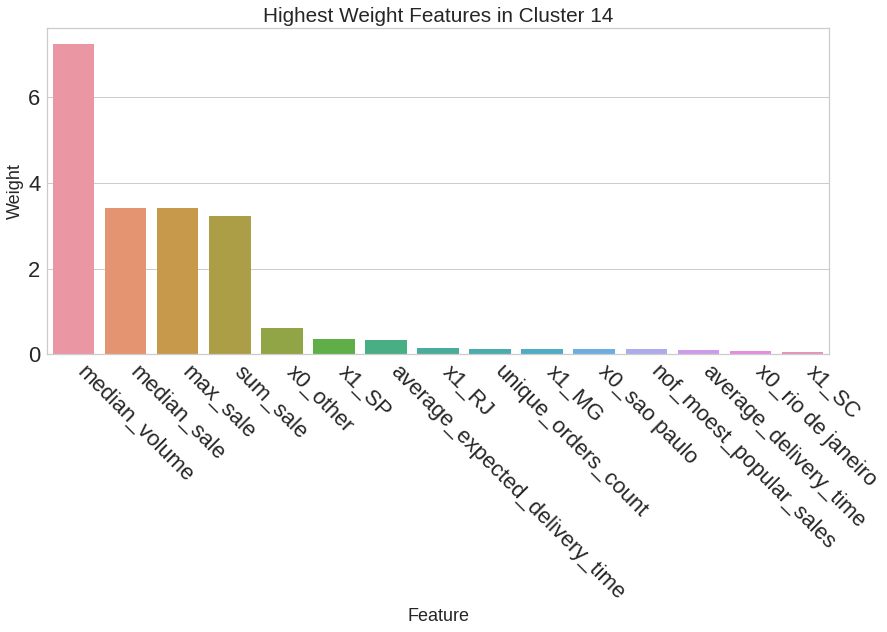

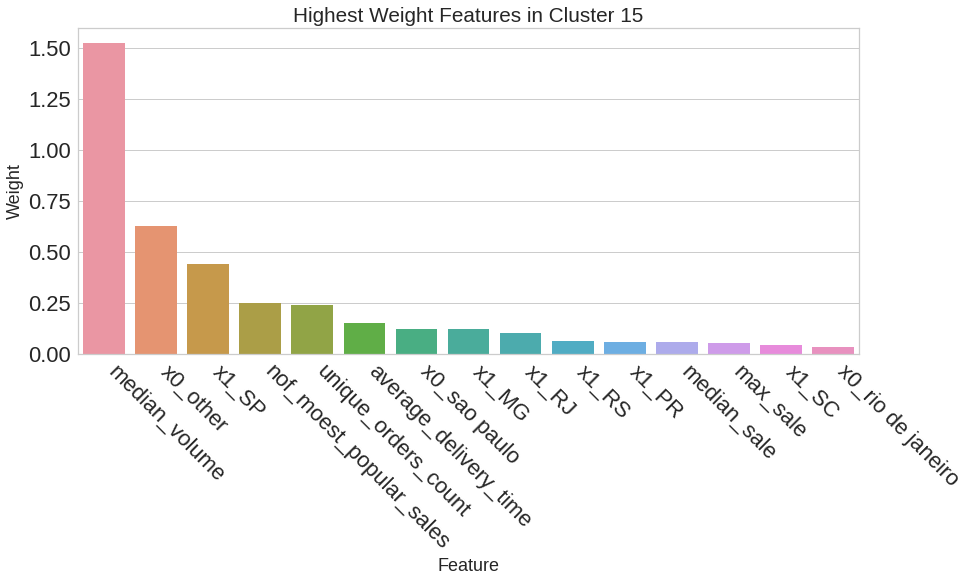

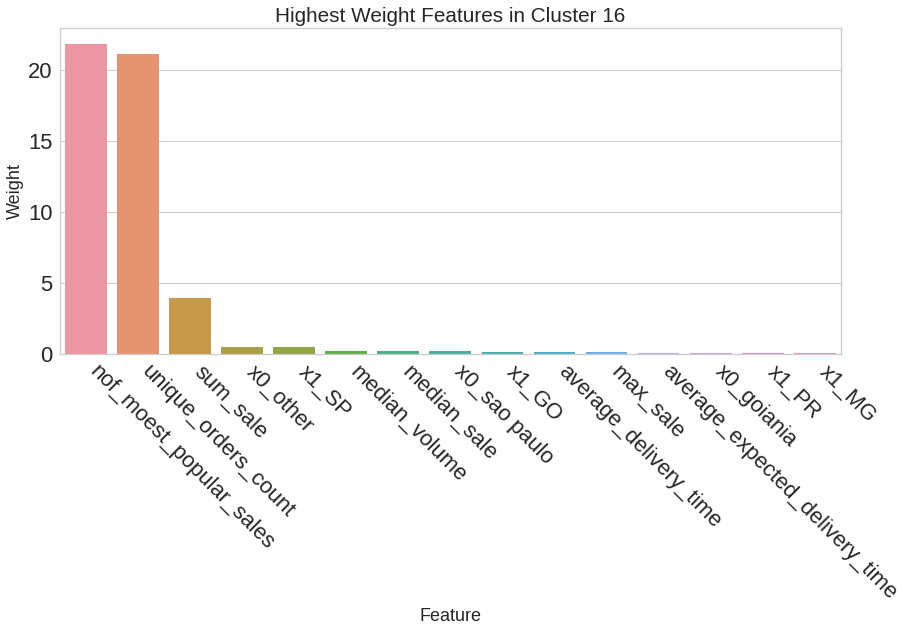

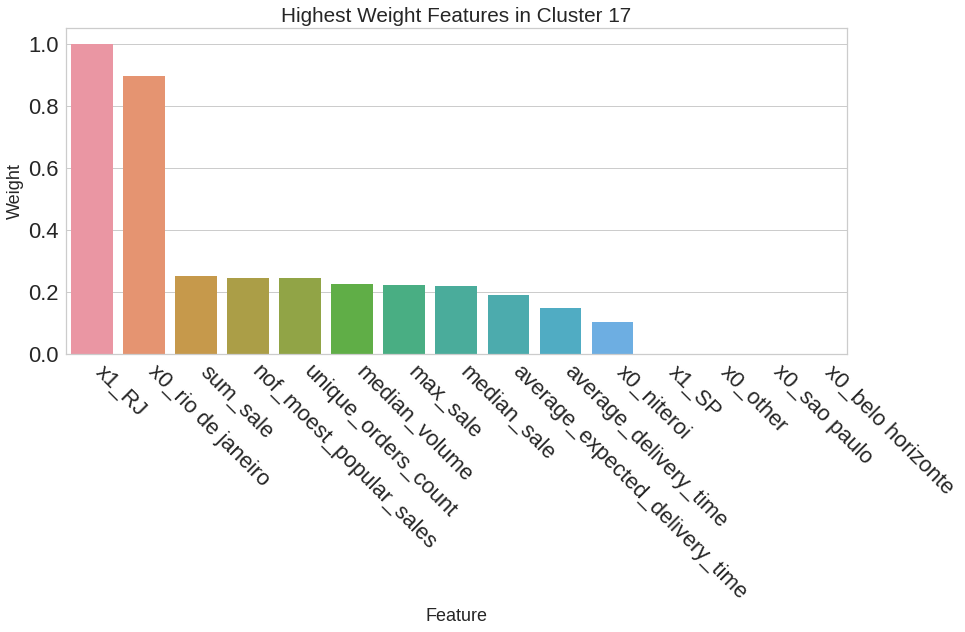

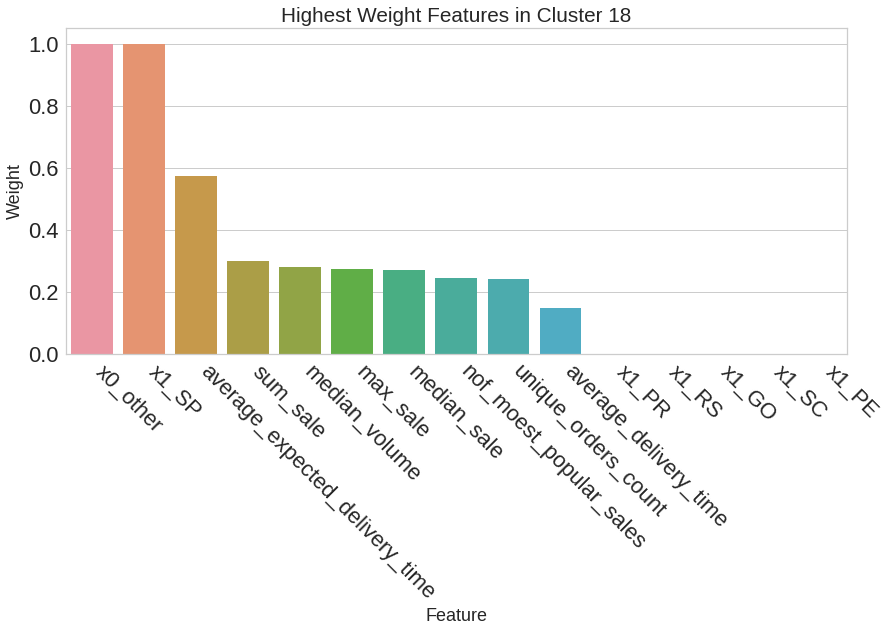

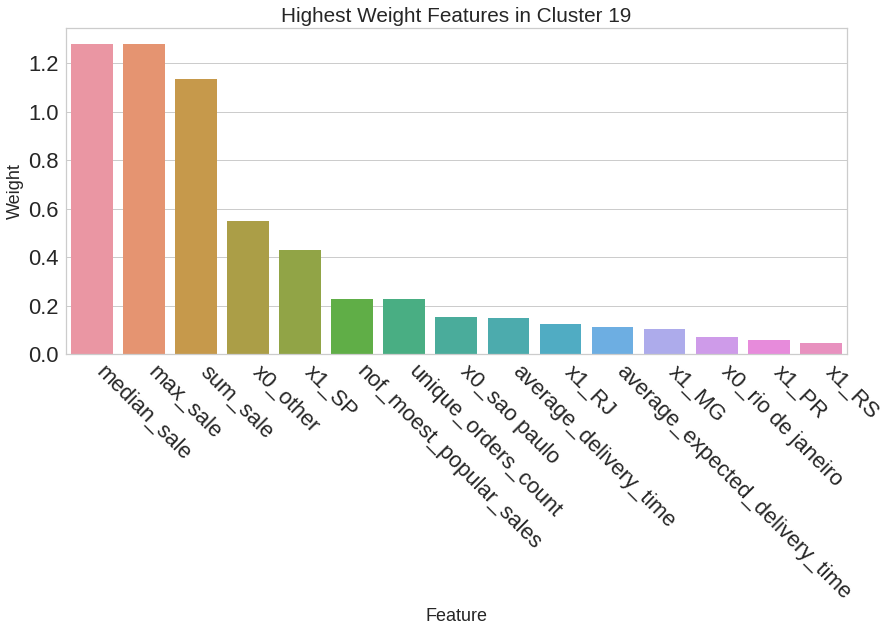

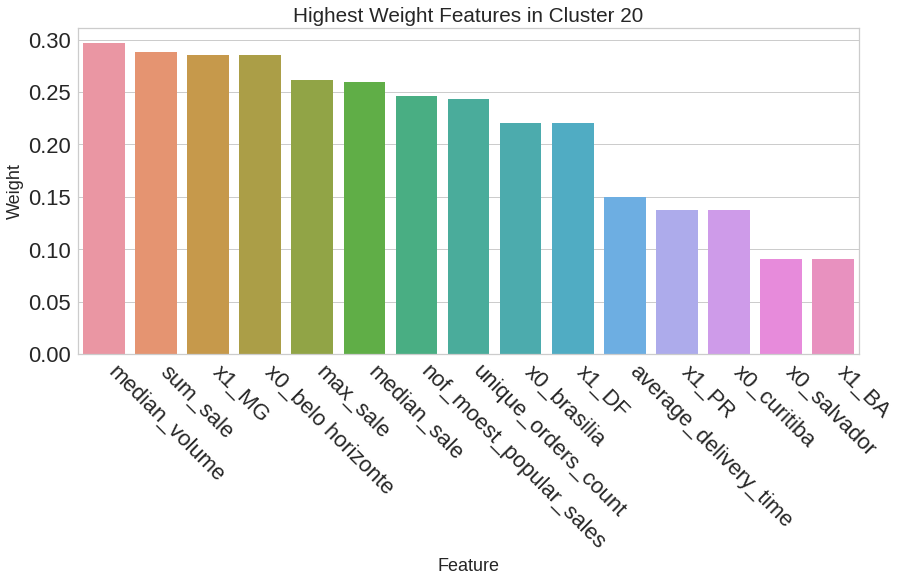

In [94]:
for cluster_label, feature_weights in interpreter.feature_importances_.items():    
    df_feature_weight = pd.DataFrame(feature_weights[:15], columns=["Feature", "Weight"])
    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left");
    ax.tick_params(axis='both', which='major', labelsize=22)
    plt.title(f'Highest Weight Features in Cluster {cluster_label}', fontsize='xx-large')
    plt.xlabel('Feature', fontsize=18)
    plt.ylabel('Weight', fontsize=18)

    plt.show();
    
    print('\n\n')

In [95]:
cols

Index(['unique_orders_count', 'nof_moest_popular_sales', 'max_sale',
       'median_sale', 'sum_sale', 'median_volume', 'average_delivery_time',
       'average_expected_delivery_time'],
      dtype='object')

In [102]:
df2.loc[df2["cluster"] == 2,"max_sale"].to_numpy()

array([59.9, 49.9, 24.9, ...,  6.9, 35. , 49. ])

In [132]:
df2.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'unique_orders_count', 'nof_moest_popular_sales',
       'max_sale', 'median_sale', 'sum_sale', 'median_volume',
       'average_delivery_time', 'average_expected_delivery_time', 'x', 'y',
       'outlier', 'cluster'],
      dtype='object')

<AxesSubplot:ylabel='Count'>

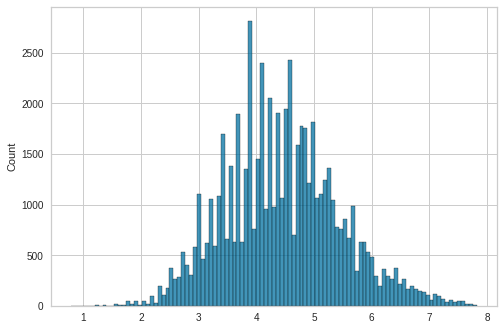

In [214]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([17,18,0,7,13,15,]),"max_sale"].to_numpy()))

<AxesSubplot:ylabel='Count'>

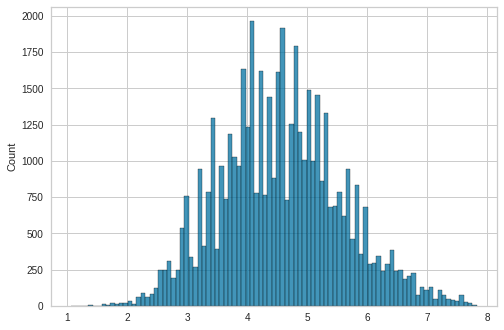

In [232]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([5,6,16,17,18,0,7,13,15,10]),"max_sale"].to_numpy()))

<AxesSubplot:ylabel='Count'>

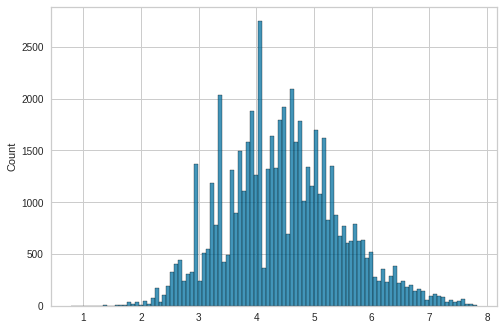

In [231]:
sns.histplot(np.log(df2.loc[~df2["cluster"].isin([5,6,16,17,18,0,7,13,15]),"max_sale"].to_numpy()))

In [114]:
from scipy.stats import kstest

In [146]:
for i in range(0,21):
    data = np.log(df2.loc[df2["cluster"] == i,"max_sale"].to_numpy())
    mean = np.mean(data)
    std = np.std(data)
    if kstest((data-mean)/std, 'norm').pvalue > 0.05 :
        print(kstest((data-mean)/std, 'norm').pvalue)
        print(i)

0.2964482996398481
5
0.5658350740840601
6
0.4830518375829337
16


In [124]:
for i in range(0,21):
    data = df2.loc[df2["cluster"] == i,"max_sale"].to_numpy()
    mean = np.mean(data)
    std = np.std(data)
    if kstest((data-mean)/std, 'norm').pvalue > 0.05 :
        print(i)

16


<AxesSubplot:xlabel='max_sale', ylabel='Count'>

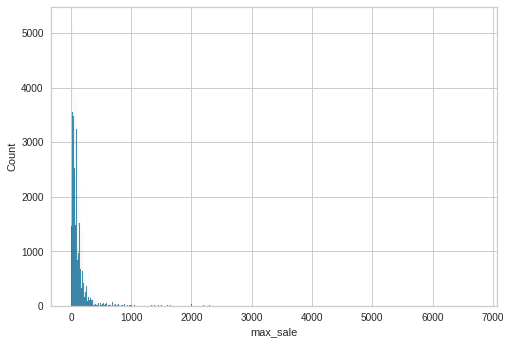

In [129]:
sns.histplot(df2["max_sale"])